In [4]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
from dataprep import *
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
#from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

In [1]:
#train_adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

NameError: name 'sc' is not defined

In [4]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
conditions = [
    (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
]

choices = ['strong', 'intermediate', 'low']

adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [4]:
pericellular_dict_low = subsetGenes(adata, 'pericellular', pattern_strength = 0.9, count_threshold = 11, high_or_low = 'low')

In [5]:
pericellular_dict_high = subsetGenes(adata, 'pericellular', pattern_strength=0.9, count_threshold = 140, high_or_low = 'high')

In [6]:
pericellular_dict_mixed = subsetGenes(adata, 'pericellular', pattern_strength=0.9, mixed_counts=True)

In [ ]:
random_dict_mixed = subsetGenes(adata, 'random', mixed_counts=True)

In [8]:
random_dict_low = subsetGenes(adata, 'random', count_threshold = 11, high_or_low = 'low', mixed_counts=False)

In [9]:
random_dict_high = subsetGenes(adata, 'random', count_threshold = 140, high_or_low = 'high', mixed_counts=False)

## Plan of attack

1. predict all the items within a single dictionary.
2. Do the same for the random genes.
3. group results together in a dataframe. Columns: RF_results, group, pattern (so can subset for the patterns when doing regression)
4. do logistic regression on the dataframe to see if there is a significant difference

## Check f1 score for protrusion data with pattern strength 0.45 iso 0.9

In [59]:
adata_all = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")

In [72]:
adata_all[adata_all.obs['pattern']=='protrusion']

View of AnnData object with n_obs × n_vars = 0 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    uns: 'neighbors', 'pattern_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'latent'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [73]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd

In [74]:
adata_concat = ad.concat([adata_all,adata_protrude], merge="same")
adata_concat[adata_concat.obs['pattern']=='protrusion']

View of AnnData object with n_obs × n_vars = 37979 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    obsm: 'latent'

In [70]:
protrude_adata = adata[adata.obs['pattern']=='protrusion']
adata_protrude = protrude_adata[protrude_adata.obs['prop']==0.4]
adata_protrude

View of AnnData object with n_obs × n_vars = 37979 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    obsm: 'latent'

In [78]:
# Step 1: Group indices by cell_id
all_indices = adata_concat.obs.index
cell_ids = np.array(adata_concat.obs['cell_id'])
unique_cell_ids, cell_id_indices = np.unique(cell_ids, return_inverse=True)

# Step 3: Perform train-val-test split on cell_ids, maintaining the grouping
train_indices, test_val_indices = skm.train_test_split(np.arange(len(unique_cell_ids)), test_size=0.2, random_state=seed)
val_indices, test_indices = skm.train_test_split(test_val_indices, test_size=0.5, random_state=seed)

# Step 4: Map the grouped indices back to the original indices
train_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in train_indices])
val_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in val_indices])
test_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in test_indices])

# Step 5: Subset AnnData object using the obtained indices
adata_train = adata_concat[train_indices, :] # Training set:   176162 x 15
adata_val = adata_concat[val_indices, :]     # Validation set: 22269 x 15
adata_test = adata_concat[test_indices, :]   # Test set:       22256 x 15

In [79]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_val_pattern = adata_val.copy()
adata_val_pattern = adata_val_pattern[adata_val_pattern.obs['pattern']!='random']

<ipython-input-80-5f17c46949c9>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train_pattern.obs["protrusion"] = np.where(adata_train_pattern.obs["pattern"] == "protrusion", "protrusion", "other")
<ipython-input-80-5f17c46949c9>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_val_pattern.obs["protrusion"] = np.where(adata_val_pattern.obs["pattern"] == "protrusion", "protrusion", "other")


f1 score: 
0.8601307189542483


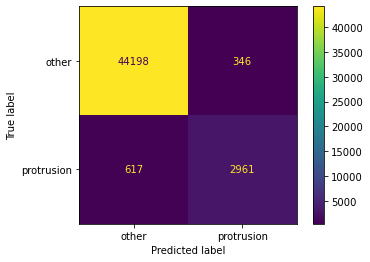

In [80]:
adata_train_pattern.obs["protrusion"] = np.where(adata_train_pattern.obs["pattern"] == "protrusion", "protrusion", "other")
adata_val_pattern.obs["protrusion"] = np.where(adata_val_pattern.obs["pattern"] == "protrusion", "protrusion", "other")
 # create random forest classifier EXCLUDING random
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_classifier.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["protrusion"]) 
    
#predict label
val_protrusion = rf_classifier.predict(adata_val_pattern.obsm["latent"])

print("f1 score: ")
print(f1_score(adata_val_pattern.obs["protrusion"], val_protrusion, pos_label='protrusion'))

confusion_matrix = metrics.confusion_matrix(adata_val_pattern.obs["protrusion"], val_protrusion, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

## Load RF trained objects

In [5]:
import pickle

patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
models = {}

for pattern in patterns:
    # Specify the path where the model is saved
    path = f"temp_objects/rf_{pattern}.pkl"

    # Open the file in read-binary mode and load the model
    with open(path, 'rb') as p:
        models[pattern] = pickle.load(p)

## RF score: pattern / no pattern for less pretty data

In [30]:
rf_classifier = models['pattern']
adata_mid = adata[adata.obs['prop']==0.5]
adata_low = adata[adata.obs['prop']==0.1]
adata_protrusion_mid = adata[(adata.obs['prop']==0.4)&(adata.obs['pattern']=='protrusion')]
adata_protrusion_low = adata[(adata.obs['prop']==0.0) &(adata.obs['pattern']=='protrusion')]


In [ ]:
adata_strong = anndata.concat(adata[adata.obs['prop']==0.9],adata[(adata.obs['prop']==0.4)&(adata.obs['pattern']=='protrusion')])
adata_mid = anndata.concat(adata[adata.obs['prop']==0.5],adata[(adata.obs['prop']==0.2)&(adata.obs['pattern']=='protrusion')])
adata_low = anndata.concat(adata[adata.obs['prop']==0.1],adata[(adata.obs['prop']==0.0)&(adata.obs['pattern']=='protrusion')])

In [35]:
conditions = [
    (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
]

choices = ['strong', 'intermediate', 'low']

adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [17]:
adata_mid

View of AnnData object with n_obs × n_vars = 504404 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    obsm: 'latent'

In [29]:
adata_protrusion_mid.obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,prop,prop_interval,corresponding_dapis,train_or_val,original_image_paths
1324002,protrusion,pattern,100,100+,36,blank,12,0-60,1.5,0.4,0.3-0.4,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...
1324003,protrusion,pattern,100,100+,36,blank,21,0-60,1.5,0.4,0.3-0.4,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...
1324004,protrusion,pattern,100,100+,36,blank,238,180-240,1.5,0.4,0.3-0.4,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...
1324005,protrusion,pattern,100,100+,36,blank,277,240-300,1.5,0.4,0.3-0.4,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...
1324006,protrusion,pattern,100,100+,36,blank,31,0-60,1.5,0.4,0.3-0.4,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437909,protrusion,pattern,9,0-10,164,blank,100,60-120,1.5,0.4,0.3-0.4,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...
1437910,protrusion,pattern,9,0-10,164,blank,151,120-180,1.5,0.4,0.3-0.4,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...
1437911,protrusion,pattern,9,0-10,164,blank,266,240-300,1.5,0.4,0.3-0.4,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...
1437912,protrusion,pattern,9,0-10,164,blank,345,300+,1.5,0.4,0.3-0.4,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...


In [23]:
import anndata

In [28]:
adata_total_mid = anndata.concat([adata_mid, adata_protrusion_mid], merge='same')
adata_total_low = anndata.concat([adata_low, adata_protrusion_low], merge='same')

### Count Bins

In [47]:
adata[adata.obs['pattern_strength']=='high'].obs['n_spots_interval'].value_counts()

AnnData object with n_obs × n_vars = 1627152 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
    obsm: 'latent'

In [51]:
counts = adata.obs['n_spots_interval'].unique()
pattern_strength = adata.obs['pattern_strength'].unique()
pattern_strength

array(['strong', 'low', 'intermediate'], dtype=object)

In [49]:
for count in counts:
    adata_count = adata[(adata.obs['n_spots_interval']==count)&(adata.obs['pattern_strength']=='strong')]
    rf_score = rf_classifier.predict(adata_count.obsm["latent"])

    print(f"f1 score for {count}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern'))

    confusion_matrix = metrics.confusion_matrix(adata_count.obs["random_or_pattern"],rf_score, labels = rf_classifier.classes_)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
    cm_display.plot()
    plt.savefig(f'images/confusion_matrix/pattern_strong_{count}.png')
    plt.close()

f1 score for 100+:  0.9898959760901778
f1 score for 0-10:  0.9385078944196698
f1 score for 10-20:  0.9473576102585171
f1 score for 20-30:  0.9645491742078071
f1 score for 30-40:  0.9690537987805815
f1 score for 40-50:  0.9763023057216056
f1 score for 50-60:  0.9806172839506174
f1 score for 70-80:  0.9823669143622853
f1 score for 80-90:  0.9847821492194813
f1 score for 90-100:  0.9869442915672966


In [22]:
#inverse F1 (for the TN)
for count in counts:
    adata_count = adata[(adata.obs['n_spots_interval']==count)&(adata.obs['pattern_strength']=='strong')]
    rf_score = models['pattern'].predict(adata_count.obsm["latent"])

    print(f"f1 score for {count}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='random'))

    confusion_matrix = metrics.confusion_matrix(adata_count.obs["random_or_pattern"],rf_score, labels = models['pattern'].classes_)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = models['pattern'].classes_) 
    cm_display.plot()
    plt.savefig(f'images/confusion_matrix/pattern_strong_{count}.png')
    plt.close()

f1 score for 100+:  0.9248306997742664
f1 score for 0-10:  0.14309707759489418
f1 score for 10-20:  0.4825497548312662
f1 score for 20-30:  0.6797085806799783
f1 score for 30-40:  0.750711369541012
f1 score for 40-50:  0.8193023255813954
f1 score for 50-60:  0.8481624758220503
f1 score for 70-80:  0.8524088707621719
f1 score for 80-90:  0.8702702702702703
f1 score for 90-100:  0.9025114155251142


In [53]:
for strength in pattern_strength:
    for count in counts:

        adata_count = adata[(adata.obs['n_spots_interval']==count)&(adata.obs['pattern_strength']==strength)]
        rf_score = rf_classifier.predict(adata_count.obsm["latent"])

        print(f"f1 score for {count} & {strength}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern'))

        confusion_matrix = metrics.confusion_matrix(adata_count.obs["random_or_pattern"],rf_score, labels = rf_classifier.classes_)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
        cm_display.plot()
        plt.savefig(f'images/confusion_matrix/pattern_{strength}_{count}.png')
        plt.close()

f1 score for 100+ & strong:  0.9898959760901778
f1 score for 0-10 & strong:  0.9385078944196698
f1 score for 10-20 & strong:  0.9473576102585171
f1 score for 20-30 & strong:  0.9645491742078071
f1 score for 30-40 & strong:  0.9690537987805815
f1 score for 40-50 & strong:  0.9763023057216056
f1 score for 50-60 & strong:  0.9806172839506174
f1 score for 70-80 & strong:  0.9823669143622853
f1 score for 80-90 & strong:  0.9847821492194813
f1 score for 90-100 & strong:  0.9869442915672966
f1 score for 100+ & low:  0.19111762102275578
f1 score for 0-10 & low:  0.9066160177271287
f1 score for 10-20 & low:  0.7511935045475137
f1 score for 20-30 & low:  0.6141176942034503
f1 score for 30-40 & low:  0.49675856198022394
f1 score for 40-50 & low:  0.42207109303793033
f1 score for 50-60 & low:  0.35429678044057134
f1 score for 70-80 & low:  0.3158668593302406
f1 score for 80-90 & low:  0.26507717535594366
f1 score for 90-100 & low:  0.2451623094542295
f1 score for 100+ & intermediate:  0.8210173400

In [21]:
adata_test.obs['random_or_pattern'].value_counts()

random    8037
Name: random_or_pattern, dtype: int64

In [19]:
adata_test = adata[(adata.obs['n_spots_interval']=='0-10')&(adata.obs['pattern']=='random')]
rf_score = models['pattern'].predict(adata_test.obsm["latent"])
f1_score(adata_test.obs["random_or_pattern"], rf_score, pos_label='pattern')

0.0

In [14]:
scores = {}
for count in counts:
    adata_count = adata[(adata.obs['n_spots_interval']==count)&(adata.obs['pattern']=='random')]
    rf_score = models['pattern'].predict(adata_count.obsm["latent"])

    scores[count] = f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern')

    confusion_matrix = metrics.confusion_matrix(adata_count.obs["random_or_pattern"],rf_score, labels = models['pattern'].classes_)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = models['pattern'].classes_) 
    cm_display.plot()
    plt.savefig(f'images/confusion_matrix/pattern_random_{count}.png')
    plt.close()
scores

{'100+': 0.0,
 '0-10': 0.0,
 '10-20': 0.0,
 '20-30': 0.0,
 '30-40': 0.0,
 '40-50': 0.0,
 '50-60': 0.0,
 '70-80': 0.0,
 '80-90': 0.0,
 '90-100': 0.0}

In [23]:
scores = {}
for count in counts:
    adata_count = adata[(adata.obs['n_spots_interval']==count)&(adata.obs['pattern']=='random')]
    rf_score = models['pattern'].predict(adata_count.obsm["latent"])

    scores[count] = f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='random')
scores

{'100+': 0.9647086673198445,
 '0-10': 0.14108939516595354,
 '10-20': 0.5318339487523778,
 '20-30': 0.7340600268777064,
 '30-40': 0.8091042584434656,
 '40-50': 0.8721093650185255,
 '50-60': 0.896106727122117,
 '70-80': 0.9153478584893253,
 '80-90': 0.929637526652452,
 '90-100': 0.9469351519309149}

In [8]:
scores = {}
pattern_strength = adata.obs['pattern_strength'].unique()
counts = adata.obs['n_spots_interval'].unique()
patterns = adata.obs['pattern'].unique()

for strength in pattern_strength:
    for pattern in patterns:
        for count in counts:

            adata_count = adata[(adata.obs['n_spots_interval']==count)&(adata.obs['pattern_strength']==strength)&(adata.obs['pattern']==pattern)]
            rf_score = models['pattern'].predict(adata_count.obsm["latent"])

            score = f"{pattern}_{strength}_{count}"

            scores[score] = f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern')

            confusion_matrix = metrics.confusion_matrix(adata_count.obs["random_or_pattern"],rf_score, labels = models['pattern'].classes_)
            cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = models['pattern'].classes_) 
            cm_display.plot()
            plt.savefig(f'images/confusion_matrix/pattern_{pattern}_{strength}_{count}.png')
            plt.close()

Cell below doesn't work because none of them are true negative. Only works on overall level. On this level would only really be able to test for the accuracy. 

In [ ]:
scores = {}
pattern_strength = adata.obs['pattern_strength'].unique()
counts = adata.obs['n_spots_interval'].unique()
patterns = adata[adata.obs['pattern']!='random'].obs['pattern'].unique()

for strength in pattern_strength:
    for pattern in patterns:
        for count in counts:

            adata_count = adata[(adata.obs['n_spots_interval']==count)&(adata.obs['pattern_strength']==strength)&(adata.obs['pattern']==pattern)]
            rf_score = models['pattern'].predict(adata_count.obsm["latent"])

            score = f"{pattern}_{strength}_{count}"

            scores[score] = f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='random')

with open('dict_f1_TN.csv', 'w') as f:
    writer = csv.writer(f)
    for key, values in scores.items():
        writer.writerow([key] + [str(values)])

In [12]:
import csv

with open('dict.csv', 'w') as f:
    writer = csv.writer(f)
    for key, values in scores.items():
        writer.writerow([key] + [str(values)])

### Pattern strength

f1 score: 
0.8372259184980033


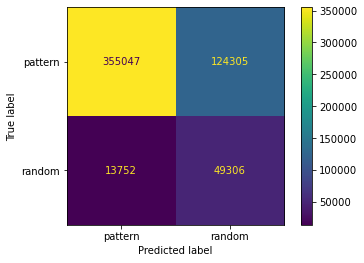

In [38]:
adata_test = adata[adata.obs['pattern_strength']=='intermediate']
mid_score = rf_classifier.predict(adata_test.obsm["latent"])

print("f1 score: ")
print(f1_score(adata_test.obs["random_or_pattern"], mid_score, pos_label='pattern'))

confusion_matrix = metrics.confusion_matrix(adata_test.obs["random_or_pattern"], mid_score, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

f1 score: 
0.3918086889597642


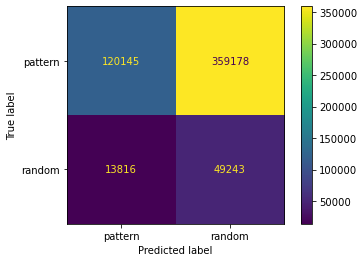

In [32]:
low_score = rf_classifier.predict(adata_total_low.obsm["latent"])

print("f1 score: ")
print(f1_score(adata_total_low.obs["random_or_pattern"], low_score, pos_label='pattern'))

confusion_matrix = metrics.confusion_matrix(adata_total_low.obs["random_or_pattern"], low_score, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

### Initial exploration

In [9]:
# create random forest classifier and fit on training data
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_classifier.fit(train_adata.obsm["latent"], train_adata.obs["random_or_pattern"])
    
#predict label

RandomForestClassifier(max_features=3, n_estimators=150, random_state=101)

In [ ]:
rf_classifier

In [16]:
random_pred = rf_classifier.predict(random_dict_mixed.get(0).obsm["latent"])
pericellular_pred = rf_classifier.predict(pericellular_dict.get(0).obsm["latent"])

In [19]:
np.unique(pericellular_pred)

array(['pattern'], dtype=object)

In [22]:
from collections import Counter
Counter(random_pred)

Counter({'random': 251, 'pattern': 66})

In [24]:
random_low_pred = rf_classifier.predict(random_dict_low.get(0).obsm["latent"])
Counter(random_low_pred)

Counter({'random': 21, 'pattern': 232})

In [24]:
models.get('pericellular').predict_proba(random_dict_mixed.get(0).obsm["latent"])

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.99333333, 0.00666667],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.99333333, 0.00666667],
       [1.        , 0.        ],
       [0.98      , 0.02      ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.

In [49]:
models.get('pericellular').predict_proba(pericellular_dict.get(0).obsm["latent"])

array(['other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other',
       'pericellular', 'other', 'pericellular', 'other', 'other', 'other',
       'pericellular', 'other', 'other', 'other', 'pericellular',
       'pericellular', 'other', 'other', 'pericellular', 'other',
       'pericellular', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'pericellular', 'other',
       'other', 'other', 'other', 'other', 'other', 'pericellular',
       'other', 'other', 'pericellular', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'pericellular', 'other', 'other',
       'pericellular', 'other', 'other', 'other', 'other', 'pericellular',
       'other', 'other', 'other', 'other', 'other', 'pericellular',
       'other', 'other', 'pericellular', 'other', 'other', 'pericellular',
       'other', 'other', 'other', 

In [40]:
from collections import Counter
print(Counter(models.get('pericellular').predict(pericellular_dict.get(3).obsm["latent"])))
print(Counter(models.get('pericellular').predict(random_dict_mixed.get(3).obsm["latent"])))
print(Counter(models.get('pericellular').predict(random_dict_low.get(3).obsm["latent"])))

Counter({'other': 229, 'pericellular': 29})
Counter({'other': 317})
Counter({'other': 252, 'pericellular': 1})


In [53]:
np.array(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Create dataframe

In [ ]:
rows = []

gene_id = np.array(range(10))
for pattern in patterns:
    for i in range(10):
        pericellular_low = models.get(pattern).predict_proba(pericellular_dict_low.get(i).obsm["latent"])[:,0]
        pericellular_mixed = models.get(pattern).predict_proba(pericellular_dict_mixed.get(i).obsm["latent"])[:,0]
        pericellular_high = models.get(pattern).predict_proba(pericellular_dict_high.get(i).obsm["latent"])[:,0]
        random_mixed = models.get(pattern).predict_proba(random_dict_mixed.get(i).obsm["latent"])[:,0]
        random_low = models.get(pattern).predict_proba(random_dict_low.get(i).obsm["latent"])[:,0]
        random_high = models.get(pattern).predict_proba(random_dict_high.get(i).obsm["latent"])[:,0]
        for value in pericellular_low:
            rows.append({'prob_pattern': value, 'group': 'pericellular', 'pattern': pattern, 'gene_id': i})
        for value in pericellular_mixed:
            rows.append({'prob_pattern': value, 'group': 'pericellular_mixed', 'pattern': pattern, 'gene_id': i})
        for value in pericellular_high: 
            rows.append({'prob_pattern': value, 'group': 'pericellular_high', 'pattern': pattern, 'gene_id': i})
        for value in random_mixed:
            rows.append({'prob_pattern': value, 'group': 'random_mixed', 'pattern': pattern, 'gene_id': i})
        for value in random_low:
            rows.append({'prob_pattern': value, 'group': 'random_low', 'pattern': pattern, 'gene_id': i})
        for value in random_high:
            rows.append({'prob_pattern': value, 'group': 'random_high', 'pattern': pattern, 'gene_id': i})
df = pd.DataFrame(rows)

In [13]:
gene_id = np.array(range(10))
groups = ['pericellular_low', 'pericellular_mixed', 'pericellular_high', 'random_mixed', 'random_low', 'random_high']
dicts = ['pericellular_dict_low', 'pericellular_dict_mixed', 'pericellular_dict_high', 'random_dict_mixed', 'random_dict_low', 'random_dict_high']

rows = [
    {
        'prob_pattern': value, 
        'group': group, 
        'pattern': pattern, 
        'gene_id': i
    }
    for pattern in patterns
    for i in range(10)
    for group, dict_name in zip(groups, dicts)
    for value in models.get(pattern).predict_proba(globals()[dict_name].get(i).obsm["latent"])[:,0]
]

df = pd.DataFrame(rows)

In [14]:
df[df['pattern']=='pericellular']

,prob_pattern,group,pattern,gene_id
103740,0.913333,pericellular_low,pericellular,0
103741,0.746667,pericellular_low,pericellular,0
103742,0.860000,pericellular_low,pericellular,0
103743,0.586667,pericellular_low,pericellular,0
103744,1.000000,pericellular_low,pericellular,0
...,...,...,...,...
121025,1.000000,random_high,pericellular,9
121026,1.000000,random_high,pericellular,9
121027,1.000000,random_high,pericellular,9
121028,1.000000,random_high,pericellular,9


In [15]:
import statsmodels.formula.api as smf

In [85]:
model = smf.ols("prob_pattern ~ group + gene_id", data= df[df['pattern'] == 'pericellular']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           prob_pattern   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     2485.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:46:24   Log-Likelihood:                 5695.5
No. Observations:                7256   AIC:                        -1.138e+04
Df Residuals:                    7252   BIC:                        -1.136e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.7374      0.003    244.876      0.000       0.731       0.743
group[T.random_low]       0.2266      0.003     65.606      0.000       0.220       0.233
group[T.random_mixed]     0.2603      0.003     82.671      0.000       0.254       0.266
gene_id                  -0.0002      0.000     -0.364      0.716      -0.001       0.001
==============================================================================
Omnibus:                     2520.897   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14825.853
Skew:                          -1.545   Prob(JB):                         0.00
Kurtosis:                       9.284   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
from scipy import stats

Text(0.5, 1.0, 'Model1 Residuals Q-Q Plot')

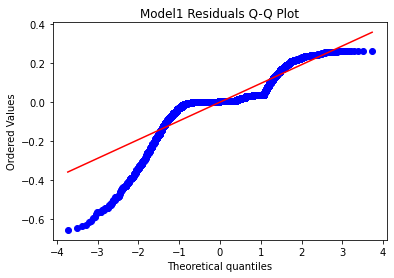

In [89]:
#Running plot & giving it a title
stats.probplot(model.resid, dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")


In [64]:
df['pattern'].unique()

array(['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear',
       'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion'],
      dtype=object)

## Histogram pattern/no pattern

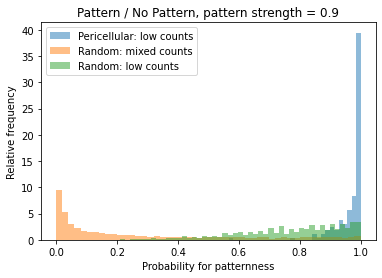

In [122]:
pattern = 'pattern'
pericellular = df[(df['pattern'] == pattern) & (df['group']=='pericellular_low') & (df['gene_id']==0)]
random_mixed = df[(df['pattern'] == pattern) & (df['group']=='random_mixed')]
random_low = df[(df['pattern'] == pattern) & (df['group']=='random_low')]

plt.hist(pericellular['prob_pattern'], bins=30, alpha=0.5, label='Pericellular: low counts', density=True)
plt.hist(random_mixed['prob_pattern'], bins=50, alpha=0.5, label='Random: mixed counts', density=True)
plt.hist(random_low['prob_pattern'], bins=50, alpha=0.5, label='Random: low counts', density=True)

plt.title("Pattern / No Pattern, pattern strength = 0.9")
plt.ylabel("Relative frequency")
plt.xlabel("Probability for patternness")
plt.legend(loc='upper left')
plt.show()

In [78]:
pericellular = df[(df['pattern'] == pattern) & (df['group']=='pericellular_high')]
pericellular['prob_pattern'].value_counts()

1.000000    2469
0.993333     149
0.986667      17
0.980000       3
0.966667       1
0.973333       1
Name: prob_pattern, dtype: int64

In [121]:
pericellular = df[(df['pattern'] == pattern) & (df['group']=='random_mixed')]
len(pericellular['prob_pattern'].unique())

151

In [110]:
12*1.25

15.0

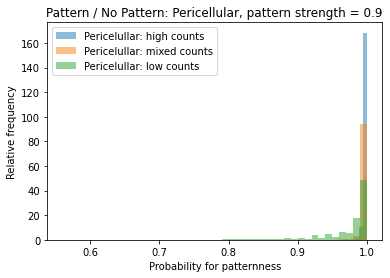

In [116]:
pattern = 'pattern'
pericellular = df[(df['pattern'] == pattern) & (df['group']=='pericellular_high')]
random_mixed = df[(df['pattern'] == pattern) & (df['group']=='pericellular_mixed')]
random_low = df[(df['pattern'] == pattern) & (df['group']=='pericellular_low')]

plt.hist(pericellular['prob_pattern'], bins=6, alpha=0.5, label='Pericelullar: high counts', density=True)
plt.hist(random_mixed['prob_pattern'], bins=24, alpha=0.5, label='Pericelullar: mixed counts', density=True)
plt.hist(random_low['prob_pattern'], bins=44, alpha=0.5, label='Pericelullar: low counts', density=True)

plt.title("Pattern / No Pattern: Pericellular, pattern strength = 0.9")
plt.ylabel("Relative frequency")
plt.xlabel("Probability for patternness")
plt.legend(loc='upper left')
plt.show()

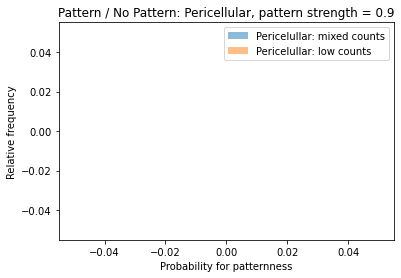

In [87]:
pattern = 'pattern'
pericellular = df[(df['pattern'] == pattern) & (df['group']=='pericelullar_high')]
random_mixed = df[(df['pattern'] == pattern) & (df['group']=='pericelullar_mixed')]
random_low = df[(df['pattern'] == pattern) & (df['group']=='pericelullar_low')]

#plt.hist(pericellular['prob_pattern'], bins=50, alpha=0.5, label='Pericelullar: high counts', density=True)
plt.hist(random_mixed['prob_pattern'], bins=30, alpha=0.5, label='Pericelullar: mixed counts', density=True)
plt.hist(random_low['prob_pattern'], bins=30, alpha=0.5, label='Pericelullar: low counts', density=True)

plt.title("Pattern / No Pattern: Pericellular, pattern strength = 0.9")
plt.ylabel("Relative frequency")
plt.xlabel("Probability for patternness")
plt.legend(loc='upper right')
plt.show()

## Histograms per pattern

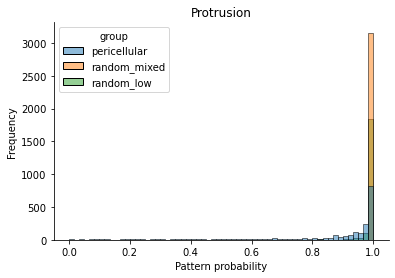

In [143]:
import seaborn as sns

ax = sns.histplot(x='prob_pattern', hue='group', data=df[df['pattern'] == 'protrusion'], bins=60)

ax.set(xlabel ="Pattern probability", 
                ylabel = "Frequency", title="Protrusion")

sns.despine()

In [130]:
import matplotlib.pyplot as plt

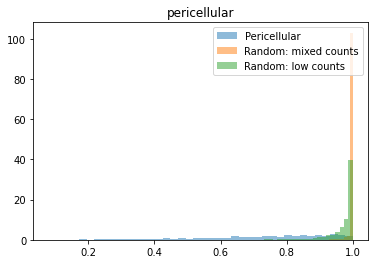

In [138]:
pattern = 'pericellular'
pericellular = df[(df['pattern'] == pattern) & (df['group']=='pericellular')]
random_mixed = df[(df['pattern'] == pattern) & (df['group']=='random_mixed')]
random_low = df[(df['pattern'] == pattern) & (df['group']=='random_low')]

plt.hist(pericellular['prob_pattern'], bins=40, alpha=0.5, label='Pericellular', density=True)
plt.hist(random_mixed['prob_pattern'], bins=40, alpha=0.5, label='Random: mixed counts', density=True)
plt.hist(random_low['prob_pattern'], bins=40, alpha=0.5, label='Random: low counts', density=True)

plt.title(pattern)
plt.legend(loc='upper right')
plt.show()

In [141]:
pericellular = df[(df['pattern'] == 'pattern') & (df['group']=='pericellular')]
random_mixed = df[(df['pattern'] == pattern) & (df['group']=='random_mixed')]
random_low = df[(df['pattern'] == pattern) & df['group']=='random_low']
random_mixed['prob_pattern']

43794    1.000000
43795    0.986667
43796    1.000000
43797    1.000000
43798    1.000000
           ...   
50635    1.000000
50636    1.000000
50637    1.000000
50638    1.000000
50639    1.000000
Name: prob_pattern, Length: 3170, dtype: float64

In [123]:
df

,prob_pattern,group,pattern,gene_id
0,0.993333,pericellular_low,pattern,0
1,0.986667,pericellular_low,pattern,0
2,1.000000,pericellular_low,pattern,0
3,1.000000,pericellular_low,pattern,0
4,0.893333,pericellular_low,pattern,0
...,...,...,...,...
155605,1.000000,random_high,protrusion,9
155606,1.000000,random_high,protrusion,9
155607,1.000000,random_high,protrusion,9
155608,1.000000,random_high,protrusion,9


In [29]:
df['pattern'].unique()

array(['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear',
       'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion'],
      dtype=object)

In [30]:
pattern = df[(df['pattern'] == 'pericellular') & (df['group']=='pericellular_low')]
pattern

,prob_pattern,group,pattern,gene_id
103740,0.913333,pericellular_low,pericellular,0
103741,0.746667,pericellular_low,pericellular,0
103742,0.860000,pericellular_low,pericellular,0
103743,0.586667,pericellular_low,pericellular,0
103744,1.000000,pericellular_low,pericellular,0
...,...,...,...,...
119543,0.746667,pericellular_low,pericellular,9
119544,0.980000,pericellular_low,pericellular,9
119545,0.866667,pericellular_low,pericellular,9
119546,0.560000,pericellular_low,pericellular,9


In [37]:
random

,prob_pattern,group,pattern,gene_id
104931,1.000000,random_low,pericellular,0
104932,0.973333,random_low,pericellular,0
104933,0.993333,random_low,pericellular,0
104934,1.000000,random_low,pericellular,0
104935,0.973333,random_low,pericellular,0
...,...,...,...,...
120708,1.000000,random_low,pericellular,9
120709,0.946667,random_low,pericellular,9
120710,1.000000,random_low,pericellular,9
120711,1.000000,random_low,pericellular,9


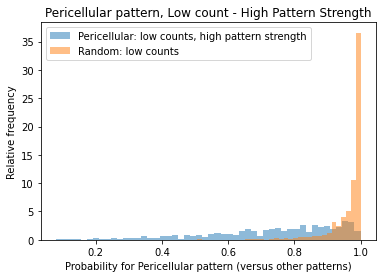

In [42]:
pattern = df[(df['pattern'] == 'pericellular') & (df['group']=='pericellular_low')]
random = df[(df['pattern'] == 'pericellular') & (df['group']=='random_low')]
plt.hist(pattern['prob_pattern'], bins=50, alpha=0.5, label='Pericellular: low counts, high pattern strength', density=True)
plt.hist(random['prob_pattern'], bins=50, alpha=0.5, label='Random: low counts', density=True)
plt.title("Pericellular pattern, Low count - High Pattern Strength")
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.legend(loc='upper left')
plt.show()

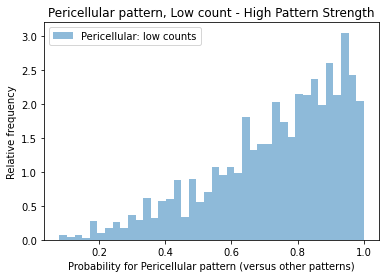

In [45]:
pattern = df[(df['pattern'] == 'pericellular') & (df['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular pattern, Low count - High Pattern Strength")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## 2-sample KS tests

In [25]:
from scipy.stats import ks_2samp
import numpy as np

In [125]:
# KS test over multiple gene_ids. 
pattern = df[(df['pattern'] == 'pattern') & (df['group']=='pericellular_low') & ]
control = df[(df['pattern'] == 'pattern') & (df['group']=='random_low')]

# Perform two-sample KS test
statistic, pvalue = ks_2samp(pattern['prob_pattern'], control['prob_pattern'])
print('Test statistic:', statistic)
print('P-value:', pvalue)

Test statistic: 0.6657273877292853
P-value: 2.6645352591003757e-15


In [26]:
# Generate two random samples from normal distributions
pattern = df[(df['pattern'] == 'pattern') & (df['group']=='pericellular_low') & (df['gene_id']==0)]
control = df[(df['pattern'] == 'pattern') & (df['group']=='random_low') & (df['gene_id']==0)]

# Perform two-sample KS test
statistic, pvalue = ks_2samp(pattern['prob_pattern'], control['prob_pattern'])
print('Test statistic:', statistic)
print('P-value:', pvalue)

Test statistic: 0.6432133511084778
P-value: 9.609041163634957e-58


In [46]:
# Generate two random samples from normal distributions
pattern = df[(df['pattern'] == 'pattern') & (df['group']=='pericellular_low') & (df['gene_id']==0)]
control = df[(df['pattern'] == 'pattern') & (df['group']=='random_low')]

# Perform two-sample KS test
statistic, pvalue = ks_2samp(pattern['prob_pattern'], control['prob_pattern'])
print('Test statistic:', statistic)
print('P-value:', pvalue)

Test statistic: 0.6652988247061765
P-value: 1.1102230246251565e-16


## Test if there is a difference between gene_id batches

In [138]:
group = 'pericellular_mixed'
test = df[(df['pattern'] == 'pattern') & (df['group']==group)]

samples = {i: test[test['gene_id'] == i] for i in range(10)}

In [139]:
stats.kruskal(*[samples[i]['prob_pattern'] for i in range(10)])

KruskalResult(statistic=5.904740445237265, pvalue=0.7494131477713668)

In [17]:
patterns

['pattern',
 'cellEdge',
 'foci',
 'extranuclear',
 'intranuclear',
 'nuclearEdge',
 'pericellular',
 'perinuclear',
 'protrusion']

In [24]:
group = 'random_mixed'

for pattern in patterns:
    print(pattern)
    test = df[(df['pattern'] == pattern) & (df['group']==group)]
    samples = {i: test[test['gene_id'] == i] for i in range(10)}
    print(stats.kruskal(*[samples[i]['prob_pattern'] for i in range(10)]))

pattern
KruskalResult(statistic=10.989882545663795, pvalue=0.276403075162644)
cellEdge
KruskalResult(statistic=4.569197135479142, pvalue=0.8701313459330914)
foci
KruskalResult(statistic=27.533327312859825, pvalue=0.00114099778375589)
extranuclear
KruskalResult(statistic=15.874466855396047, pvalue=0.06954977723313573)
intranuclear
KruskalResult(statistic=7.582558445416168, pvalue=0.5766980858947945)
nuclearEdge
KruskalResult(statistic=7.469226825933319, pvalue=0.5883872653347524)
pericellular
KruskalResult(statistic=3.695916149209883, pvalue=0.9302634264275319)
perinuclear
KruskalResult(statistic=3.771337293247917, pvalue=0.9258076937303187)
protrusion
KruskalResult(statistic=10.451222096656116, pvalue=0.31520521008206076)
